In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

--2023-05-17 01:55:03--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.4’

input.txt.4         100%[===================>]   1.06M  --.-KB/s    in 0.004s  

2023-05-17 01:55:03 (285 MB/s) - ‘input.txt.4’ saved [1115394/1115394]



In this lecture we will be building a miniature GPT (Generative Pretrained Transformer) model and using it to generate Shakespeare-like text! To train it we'll be using a text file with over 1 million characters worth of works of Shakespeare.

In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


As we've done in the past, we'll need to create a vocabulary with each of the tokens contained in our dataset. Since we are building a character-level language model this will just contain each character seen in the text. We can see that 65 different characters appear in the text.

In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In order to turn text into tokens, we need to create a numerical representation of each character. We can create functions that help us turn characters into tokens and back:

In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Then, we can encode the dataset and load it into a tensor:

In [6]:
# Now that we have an encoder, we can encode the entire dataset:
data = torch.tensor(encode(text), dtype=torch.long, device=device)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59], device='cuda:0')


Next we can split our dataset into training and validation datasets:


In [7]:
spl = int(0.9 * len(data))

train_data = data[:spl]

val_data = data[spl:]

Our input data will contain mini-batches of blocks on tokens with block size = context length = 8. This essentially means our model will be able to query the previous seven characters to predict the eigth character.

In [8]:
torch.manual_seed(1337)

batch_size = 4
context_length = 8

def get_batch(split, batch_size, context_length):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

xb, yb = get_batch('train', batch_size, context_length)

print('inputs:')
print(xb.shape)
print(xb)
print(yb.shape)
print(yb)
print('----')

for b in range(batch_size):
    for t in range(context_length):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f'when input is {context.tolist()} the target: {target}')



inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0')
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]], device='cuda:0')
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target:

Now that we have our input/label generation sorted, we can start training a model. We can start with the BigramLanguageModel we've implemented in previous lectures as a baseline. We simply look up a probabilitiy distribution in the token embedding table and use that to predict the next character.

First, we can define a few helper methods to assist with training, evaluating, and generating with our model.

In [9]:

def evaluate(model, batch_size, context_length, num_batches = 100):
    model.eval()
    x, y = get_batch('val', batch_size, context_length)
    losses = []
    for _ in range(num_batches):
        _, loss = model(x, y)
        losses.append(loss.item())
    loss = np.mean(losses)
    model.train()
    return loss


def train(model, num_steps, batch_size, context_length, learning_rate=1e-3, optimizer=None, print_every=1000, evaluate_every=1000):
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    model.train()
    losses = []
    eval_losses = []
    for step in range(1, num_steps+1):
        optimizer.zero_grad()
        x, y = get_batch('train', batch_size, context_length)
        logits, loss = model(x, y)
        loss.backward()
        optimizer.step()
        if step % print_every == 0:
            print(f'step {step}: loss {loss.item()}')

        if step == 0 or step % evaluate_every == 0:
            eval_loss = evaluate(model, batch_size, context_length)
            eval_losses.append(eval_loss)
        losses.append(loss.item())
    

    return losses, eval_losses

def plot_ema(losses, eval_losses, gamma=0.99, title='ema'):
    ema = losses[0]
    ema_losses = []
    eval_indices = np.linspace(0, len(losses), len(eval_losses), dtype=int)
    for i, l in enumerate(losses):
        ema = gamma * ema + (1-gamma) * l
        ema_losses.append(ema)
    plt.plot(ema_losses, label='train', color='red')
    plt.plot(eval_indices, eval_losses, label='val', color='blue')
    plt.legend()
    plt.show()
    print('final train loss (ema):', ema_losses[-1])
    print('final validation loss:', eval_losses[-1])

def generate_text(model, starting_text=None, max_new_tokens=1000):
    if starting_text is None:
        starting_text = ''
        data = torch.zeros((1, 1), dtype=torch.long, device=device)
    else:
        data = torch.tensor(encode(starting_text), dtype=torch.long, device=device).reshape(-1, 1)
    model.eval()
    with torch.no_grad():
        print(starting_text + decode(model.generate(data, max_new_tokens=max_new_tokens)[-1].tolist()))
    model.train()

Now we are ready to define the bigram language model. We simply initialize an embedding that maps each token to a probability distribution for the next token.

In [10]:
import torch.nn as nn
from torch.nn import functional as F

class BigramLangugageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # batch, timestep, channel

        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

m = BigramLangugageModel(vocab_size).to(device)
out, loss = m(xb, yb)
print('loss:', loss)
print(out.shape)

generate_text(m)

loss: tensor(5.0364, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([32, 65])

yq$;tfBfROkNdcuwdZZTkOMl;,ertK
w:!PLCkMBbeA$3:XaSGJO-3p&M-c?KL3auhpFYVXJFhNNNuhq$OMxv.tbVFYdXlrFZaAeNuw:cPPyREFkHDEZaYJFzyWNuX
Yo3&$LMtofBimzLB!!&V!Ox;Kl;l;ZcKe3 ixYeYEFngmi;;lxWvHFGEZEQG EsSXHB;kW3 J..Gh3;kNWjbH!selplj FGUVQS.H-hxD3pcncimVyLCbug;MniZ'X3QwkydOJlrBPUuIRnBf&ptIRlgvIg;V
F
tyqwJdqNMtS.klmoRW,Odo&$hdGCerzy3MQSTSt-&fE$HZLETxxxFhxJ$Fs:p-LK3gAY-xV-H
QAtkNxmOvnruMW,fI'
;;3QQDL!Lm:fvG,Cyy.alMUE$tptfJFEPWD?eXYIS?T.NrHK-NxWE!ar,Oyd&h&:
aadUajW,T3pEDDFkYBhoihVKNIk?e.raAnyCRrxxtp-c&fn yE?!NMyM3QNEzyEPkELmKBy.l;HXA'WWt;ROyAm 
;GHB;E$WsZE-spKXjNbVqq$V-iY.rdq$RP;$$OxxVKihpZwY'vOMugybxWEDTg
kMc-MyfvDm&tkSF-&$MDuu..J
tEAkRm&JdlMcKXjTkjxsLuzXJPLAP$VeMlv3vL-ZEACa3McLRfJ:ssF'My-vbtKH.imO:RSJ
ECAsWxVM-eRfKXALR:y,D$t'CCG!;scPkAYcKYUc-3fduMAtvn,eXrxmV
FGhZcnhob.akw!O?
w'wc-Ez
N'w:H ..!x.BPCbTmlFYF'mCREQlc?ZlcKIROMGrIpBOdF'WLLIiGubACfxImMKk
kHpZ
&XnGM.uQzXCD?tFyrK?oeIYc?oYxxiuG
l?KBEnIIZcKe y3bBGTxapQCtZF'SP

In previous lectures we've implemented our own simple SGD optimizer -- this time we can just use one of PyTorch's built-in optimizers: AdamW, which is a bit more complex but serves the same purpose.

We can use the optimizer to train the Bigram model.

step 1000: loss 3.5911130905151367
step 2000: loss 2.9266631603240967
step 3000: loss 2.736260175704956
step 4000: loss 2.548273801803589
step 5000: loss 2.480334758758545
step 6000: loss 2.5059969425201416
step 7000: loss 2.402766227722168
step 8000: loss 2.52601957321167
step 9000: loss 2.4303627014160156
step 10000: loss 2.4271392822265625


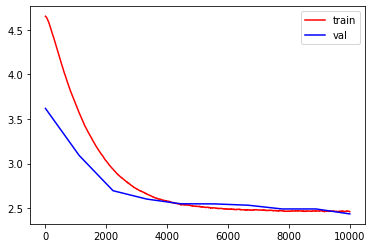

final train loss (ema): 2.46007797115696
final validation loss: 2.434309720993042


In [11]:
batch_size = 32
context_length = 8
losses, eval_losses = train(m, num_steps=10000, context_length=32, batch_size=32)
plot_ema(losses, eval_losses)

We are able to bring loss down from its initial value, but the model fails to improve much past ~2.5.

We can also try generating some tokens with our model, as you can see its still mostly giberish, but is closer to shakespearian engish than truly random characters would be (there are a few recognizable words, and words take on typical word lengths with punctuations interspersed)

In [12]:
generate_text(m)


MPrrtano iru forealoirorQUERDik;
CKES:
R tck is, d s, nd ftanofallon bay ho s, agallen, meseveminds s; te worimyoin ie--
ARUSThe Whou wowhedichea blare aned hy senInirstha theint de mas, the an be ke imyol menatoulinor woeing brwimapise.QUSwe e wo IICis;tha d tho y'silH:
FFertaperulllalop!
Antheolirconourjura d f t wothr u th?
Whaling mas, h n t il c; d j.
Whtir Whth'dlll my ay meras be:
HERGSo ndonzwel RIUCE:


Anveaban; IOn hequ thitan nu tonm TESCorte y, d.
Sl!
HAUSTRoy IE:
ARBu ar wholers e
Thins; s ookesthouk bl,-mer, s, es s;
RICld t olk ve, scee Clll!
Y theee isheresed we h, st ar
ENCELONTherveiryo derk ht kng
NG thin.
To'd!
Wheseson rwshe. ar?
EEY: s IA:
Whthathe couf mhir, byoass ooung, hathese hawaye hernd en:
BRI w flouthise ma ar h ccr:
Wivof t, ofamongl,
Youlateald weat r theat bef fowalo' I orrt bur IULENRerower lifl he pun'lf gur outo theayoourer:
Anowitens y, t y po my,
The,
I LEseng,
JUS: d bV:
EDUStho,
JUCUMy pat ingr brifo s men'ed.
Whathee s his ote h henike o an w

Next, we can implement a slightly more sophisticated model:
* we initialize a token and positional embedding table -- in addition to building embeddings for each token we also create embeddings for each relative position 
* we can then combine these embeddings into a single embedding using addition
* we can also specify the size of these embeddings, and then use a linear layer to downsample back to the desired output size (vocab size)


Note: Andrej really likes using global variables everywhere -- this gets too crazy for my liking!

In [13]:
class CoolerBigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_size, context_length) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, emb_size)
        self.positional_embedding_table = nn.Embedding(context_length, emb_size)
        self.output_layer = nn.Linear(emb_size, vocab_size)
        self.context_length = context_length

    def forward(self, idx, targets=None):
        # get token embeddings from input indices
        token_embeddings = self.token_embedding_table(idx)

        # get positional embeddings for each timestep
        B, T, C = token_embeddings.shape
        positional_embeddings = self.positional_embedding_table(torch.arange(T, device=idx.device))

        # add them together
        embeddings = token_embeddings + positional_embeddings   

        # pass thru linear layer
        logits = self.output_layer(embeddings)

        # everything else is the same as before
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    # same as before
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

This implementation should allow for the model to capture more meaning -- but we still do not expect great performance.

In [14]:
context_length = 8
batch_size = 32
emb_size = 32
cooler_model = CoolerBigramLanguageModel(vocab_size, emb_size=emb_size, context_length=context_length).to(device)
cooler_model(xb, yb)

(tensor([[ 0.9707,  0.2157, -0.0835,  ..., -0.5180,  1.3999,  0.3424],
         [ 0.2355, -0.9728, -1.3314,  ...,  0.5139, -0.9323, -0.0804],
         [ 0.4796, -0.3009, -0.7701,  ...,  0.1819, -1.4477,  0.7303],
         ...,
         [-0.2608, -0.0386,  0.5090,  ...,  1.2979,  0.9185,  0.8161],
         [ 1.6263,  0.7518,  1.3564,  ...,  0.1594,  0.4901,  0.6352],
         [-0.5124,  0.5357,  0.0302,  ...,  1.4935, -1.1639,  0.3049]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 tensor(4.5215, device='cuda:0', grad_fn=<NllLossBackward0>))

step 1000: loss 2.556856393814087
step 2000: loss 2.4927334785461426
step 3000: loss 2.4212543964385986
step 4000: loss 2.5675387382507324
step 5000: loss 2.5115902423858643
step 6000: loss 2.5174593925476074
step 7000: loss 2.4398653507232666
step 8000: loss 2.4100186824798584
step 9000: loss 2.510944366455078
step 10000: loss 2.50274920463562


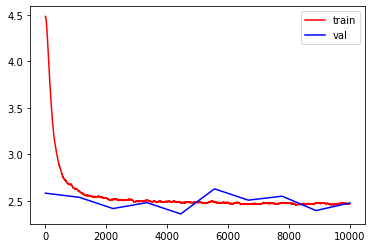

final train loss (ema): 2.4696557665964733
final validation loss: 2.476578712463379

B; e lane.
O t,
MAnd thast ay bet citinorir.

SGry, higo m fasstou s,--
AMu t htereerd
BE:
TUR:
NCAnd isenookie w I't O:
S Se f m pondetowed amand w
Sore ofouse sis is ith y de
TERe hed COfad ym o thando yo owe th mand h lomed h t:
3 ther tl mor, s



PEdshenceadad, hore mma unest s y areaseds!
Enco doley meawhe ainon maputou ourel had be.
POld sloreveke ckst da my s,
DWhad s o he dous.


ERCRY:
DChot f marerando s t I BAolllcig ht thimawoorowait ty,
y:
Jo he wek slld fofun
Asthowinequt cemaner myoue.
'lindwo.
YAS:
Ast f at st, he theighaig trvaimeloreatang.

LINA:
CENI we , ch
ARWhe wind RI I htow'd th Bveatorth:

WI tr my ak beror me m.


AS:
NI hanessloul fothere p dth me we weirg onecldil ivancut;
D:
Whiethier,

And me y s roun kered wncende issse thid bickit s is,
ALAre buto ghangr wapowht wod heBuclegunderm aiknd!
KI he.
And tishegun inde no

Le: tom bllavey t.
ASouy corimangich stourit stere;
PU

In [15]:
losses, eval_losses = train(cooler_model, 10000, batch_size=batch_size, context_length=context_length)
plot_ema(losses, eval_losses)
generate_text(cooler_model)

Next, we can implement a self-attention head as we discussed in lecture, then create a model that propogates through a self-attention head prior to the output layer:

In [16]:
class SelfAttentionHead(nn.Module):
    def __init__(self, input_channels, output_channels, context_length, dropout=0.05) -> None:
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.key = nn.Linear(input_channels, output_channels, bias=False)
        self.query = nn.Linear(input_channels, output_channels, bias=False)
        self.value = nn.Linear(input_channels, output_channels, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((context_length, context_length))))

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, idx):
        B, T, C = idx.shape
        
        # lookup query, key, and value vectors
        # C == input_channels, H == output_channels == head_size
        k = self.key(idx) # (B, T, C) -> (B, T, H)
        q = self.query(idx) # (B, T, C) -> (B, T, H)
        v = self.value(idx) # (B, T, C) -> (B, T, H)

        # compute self attention by taking dot product of query and key
        wei = q @ k.transpose(-2, -1) # (B, T, H) @ (B, H, T) -> (B, T, T)

        wei *= self.output_channels ** -0.5 # scale by sqrt of head size
        
        # apply lower triangular mask to weights
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf')) # (B, T, T)

        # apply softmax to get attention weights
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        wei = self.dropout(wei) # (B, T, T)

        # apply attention weights to values
        out = wei @ v # (B, T, T) @ (B, T, H) -> (B, T, H)

        return out # (B, T, H)
    
    
class SingleHeadModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length) -> None:
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_head = SelfAttentionHead(emb_size, head_size, context_length)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length
        

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_head(x) # (B, T, C) -> (B, T, H)
        
        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

step 1000: loss 2.5903148651123047
step 2000: loss 2.5035862922668457
step 3000: loss 2.5473358631134033
step 4000: loss 2.470447301864624
step 5000: loss 2.404531478881836
step 6000: loss 2.4041213989257812
step 7000: loss 2.371730327606201
step 8000: loss 2.3962583541870117
step 9000: loss 2.3624744415283203
step 10000: loss 2.2857131958007812


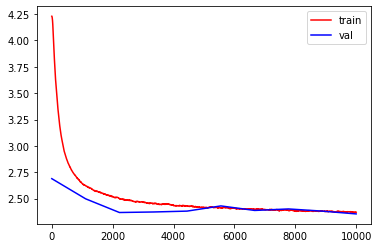

final train loss (ema): 2.37080101897375
final validation loss: 2.3541877269744873

ACUCOMANy to fo ted aly;
Whe:
Caplave:sor,
I
FUS:
Tpre ound ifr Goursemn.Foug fere couxrig, thon andsein to LO cet lf owy woulle arl nos soult bale.

IIGNof fay marm;
JUTLAUMLAULENLUK:
Thas I for poby asto kendewe he athat thar mollotr, isw heicche mersacak.

Frof ato boud they himous ullosh int get eve tthon rn!
This trant Me me,ito, berlve vimeaize thee, ter thit bura; ugs:
In hit hize, thr jadty, oro to osidenalmask, burt, fat wimom
Becn
AMy llash no we ancly;
HAR houloud thigoy giger
An.

SENor dstho lly fooleat meal and to fo arnet fo nd: fo mmary my messe hy thebes brthar king the? NI to ky theas Toute, tasn, de calirs! feade, outet me on esehe fromein.

Win gshotim. Sth; prok whan wese shiulen, oprapll oriexerodes le sacow
KIlere trenssen, been;
O se os wicemre thirgmand my mauil ghan asrey, fo nir id whato, bereme nd buble do: yout usis the?

ARRK:
A ISCAng chacth wourd!
F's df Meriesf ther
Feou

In [17]:
context_length = 32
batch_size = 32
emb_size = 32
single_head_model = SingleHeadModel(vocab_size, emb_size=emb_size, head_size=emb_size, context_length=context_length).to(device)
losses, eval_losses = train(single_head_model, 10000, batch_size, context_length)
plot_ema(losses, eval_losses)
generate_text(single_head_model)

We can see that our loss has begun to imrpove a bit, and our text now feature words that despite not being real, are at least normally-sized.

Next, instead of using a single attention head, we can try implementing Multi-Head Attention, which concatenates the results of multiple attention heads running in parallel.

The below implementation is not really parallel/vectorized, but this is a task left for the exercises (I build a vectorized implementation there).

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, context_length, head_size, num_heads) -> None:
        super().__init__()

        self.heads = nn.ModuleList([
            SelfAttentionHead(emb_size, head_size, context_length) for _ in range(num_heads)
        ])

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
    

class MultiHeadModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_heads = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_heads(x) # (B, T, C) -> (B, T, H)
        
        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

step 1000: loss 2.6322150230407715
step 2000: loss 2.461132049560547
step 3000: loss 2.4668664932250977
step 4000: loss 2.252810478210449
step 5000: loss 2.236999750137329
step 6000: loss 2.156142473220825
step 7000: loss 2.2341504096984863
step 8000: loss 2.294933795928955
step 9000: loss 2.2074332237243652
step 10000: loss 2.172811985015869


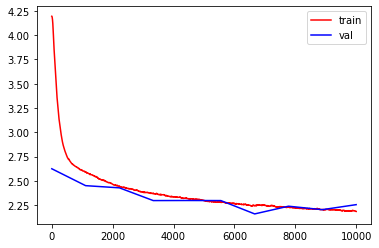

final train loss (ema): 2.1854195549095032
final validation loss: 2.2549054622650146

Bont ofs rrt mare; the Olthe the adt,
ISZY:
AnLy then, thou, wor bont, I ound ful,
Mrmm a worbirees.
Bonde
PLeclas:
KINE:
Fornt quroce, wilik imp, allil tand shouls,
Ma seredy me Polath wors:
He wames: I'rs im, kise.

For bshat, hou gan'e,
Aur yecavegay, yeineds opsey cerd cant,
I foruce rould mare exmbter, whakee,
Whit, that thal's me prouss lest, hat sfrmy thory.
DABENGE:
Sanst o'end ndan.
KINGGREO:
ILome ro his meach you; the his batens prondmy,
An, ware prof; you toy
Tof erearst bar to int bondet hand the he is for'd dee at mite,
Bulive?

This whais?

Finins ind sheiend,
Bucelald, sou theis hamulin he sa froman
weave, thre be, sirsh ster' opeat tyou.
Theang ad of wer press heat wa four cor ave f
Lad ponjotendees:
Whe me hy
AtThat nove had neis your tin wiinfaul finothflle heng, hacot at ber ons to sone,'
ghacess ig!
FLELY ANINO:
Ak qurive fors,
I wevinkss ing; hate whe wor shy,
Band ndoprsuc, wom 

In [19]:
context_length = 32
batch_size = 32
emb_size = 32
multi_head_model = MultiHeadModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=4).to(device)
losses, eval_losses = train(multi_head_model, 10000, batch_size, context_length)
plot_ema(losses, eval_losses)
generate_text(multi_head_model)

We can see that this improves our loss considerably, and we begin to see our text take on more of a structure.

In [20]:
class FeedForward(nn.Module):
    def __init__(self, input_channels, output_channels) -> None:
        super().__init__()

        self.ff = nn.Sequential(
            nn.Linear(input_channels, output_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.ff(x)
    

class MultiHeadwFFModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads,) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_heads = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_heads(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

step 1000: loss 2.535432815551758
step 2000: loss 2.3507606983184814
step 3000: loss 2.3093183040618896
step 4000: loss 2.226003408432007
step 5000: loss 2.11472487449646
step 6000: loss 2.171994686126709
step 7000: loss 2.1874945163726807
step 8000: loss 2.2079269886016846
step 9000: loss 2.1513922214508057
step 10000: loss 2.154435157775879


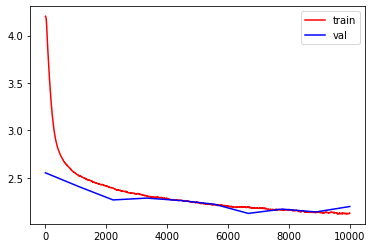

final train loss (ema): 2.127228050795009
final validation loss: 2.1988744735717773

Agr up thow; not.
OMESICIONGorkincth, to as trard Cito befe bing tho.
Tlown.

Wenour idheeat bend my it giflall. Browiy, Shust ince! wol
ar whing ther to thers chist; ther thou plepll-cen you the with ting the shey er hee, airt,
Not weazul. Grins
Ford, thingss sacpon, upown the the o belfoon:
Youlds:
Doy hore comnenciur hold wited as thous sond sprull adito! Gonill been asto to ie dams
Thingen, wrld
Then
Nust not this prot law thave and;
Whild?

LARIO:
Ree-parce
Aving fordourn, same, I I tract'
Afir musiy ord of slanson speear, ing;
giflent.

BKIZIO:
I can mave m overgeve istandroneys fole
Sear thely toh love gonte,
Haccused hemeng athe
coord oftlook, the is to thy this I clan hat whine-andwse: uper I touslous,
Ant amee, a dy I ot:
die for yous to at keingoht tland.

BOLo binenn, your
will westo uzer, seness Deaking, heer.

RORICINCER:
O ard tuve and told se thas myorquee fenthereave' youts umking you 

In [21]:
context_length = 32
batch_size = 32
emb_size = 32
multi_head_wff_model = MultiHeadwFFModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=4).to(device)
losses, eval_losses = train(multi_head_wff_model, 10000, batch_size, context_length)
plot_ema(losses, eval_losses)
generate_text(multi_head_wff_model)

Another key feature in transformers is residual connections. This allows the model to essentially read/write to/from a tape as data propagates through many self-attention blocks. Now we can scale up our model by including multiple residual blocks, and achieve much better performance.

In [22]:
class ResidualTransformerBlock(nn.Module):
    def __init__(self, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.norm1 = nn.LayerNorm(head_size)
        self.norm2 = nn.LayerNorm(head_size)

    def forward(self, x):
        x = self.attn(self.norm1(x)) + x # residual
        x = self.ff(self.norm2(x)) + x # residual
        return x
    

class MultiBlockModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads, num_blocks) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.blocks = nn.Sequential(*[ResidualTransformerBlock(emb_size, head_size, context_length, num_multi_attn_heads) for _ in range(num_blocks)], nn.LayerNorm(head_size))
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.blocks(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


step 1000: loss 2.386462450027466
step 2000: loss 2.210996150970459
step 3000: loss 2.1828184127807617
step 4000: loss 2.0228922367095947
step 5000: loss 2.0592827796936035
step 6000: loss 1.9703054428100586
step 7000: loss 1.994368553161621
step 8000: loss 1.895581841468811
step 9000: loss 2.0101773738861084
step 10000: loss 1.8981406688690186


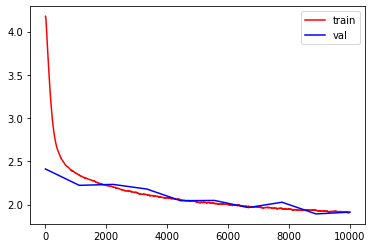

final train loss (ema): 1.910309395577402
final validation loss: 1.9129148721694946

DUth, and bletforent, in there tubch,
Und coore-but a a cesul at blistideds.
Mone beptale
Take, you
And what loly ame kantenter, and his is he ssord holive, sest you urband have vituy onguel:
You think bogabent you upuce shill do contend,
Why worst thy truth chear emaked
Mak
A were lis forter? We:

Banth will dromcey better for hath be Cinglike
This will Edy rences trrely crown.
Fiviantench news aust fracusss.

ROFY LUTIS:
How ying be prowsey plen that verencensiow
Whuch th his spoul, then is the mistger young-
Somen,
Fird they ligh event not ap.

PRICLIAnO.

HENGORS:
Sow! OF COPY:
If my heir me ke situng sonemer with dother
Revass,
Mold hisself, more to would king of counnes go me the us lomon,
lareng it on and man; yenfrers paje;
But swack all dood:
What dinew:
Benttient, day; ipore go, is dencle segrot.

CAR BETH:
To their prangely or
Ascith ceectarent thrrlon agar; thexnou for he gangh pack, me sul

In [23]:
context_length = 32
batch_size = 32
emb_size = 32
multi_block_model = MultiBlockModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=4, num_blocks=4).to(device)
losses, eval_losses = train(multi_block_model, 10000, batch_size, context_length)
plot_ema(losses, eval_losses)
generate_text(multi_block_model)

Our performance has improved dramatically, and our output text is really starting to look much more like shakespeare. Now, we can scale up the size of our model to hopefully acheive even better performance!

step 1000: loss 2.089928150177002
step 2000: loss 1.888620376586914
step 3000: loss 1.7092015743255615
step 4000: loss 1.7138113975524902
step 5000: loss 1.6130561828613281
step 6000: loss 1.6445904970169067
step 7000: loss 1.618385672569275
step 8000: loss 1.6010478734970093
step 9000: loss 1.5213872194290161
step 10000: loss 1.5830111503601074


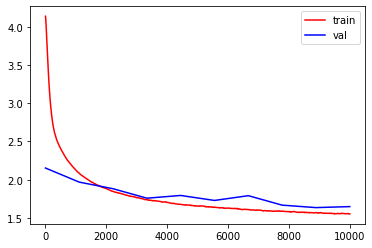

final train loss (ema): 1.553168526808115
final validation loss: 1.648468017578125

And the gaught young of
Advengerurage mook the where squickly of o't with.
Neest I cocklin cashes uppose us smatify,
As sings' grifty.

KING LENRY:
Wilt have is stands elces? for my a love,
For Lord, see with with my paintuon think,
But the sein, curchtleds be Godger's the gafter.

Lurdow them and the that brumpretice,
And secrubitatio, seconds son know,
Ins that so-that Rome, that he hour
Thank ruttone be was toth honer'd Thou To':
My lord doned your till muts exect him;
Steep with him. And shown, hast on: do constage lemn
Hast the there It England bacties to hank for she;
Sould whichder have will chiene! the have concient
Let playe: trave 'tis leave may elsh, constroath, them?

BUCKINGHAM:
By for and to maind think true. Beave they look
So your for Whence, noble gappeted his deep
Thall slim like grie'ly naming o's love greet
Plosse shorth, nor thaning becity one and suall's,
Ooth my deir of suppick'd,

In [24]:
context_length = 128
batch_size = 32
emb_size = 64
multi_block_model = MultiBlockModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=8, num_blocks=8).to(device)
losses, eval_losses = train(multi_block_model, 10000, batch_size, context_length)
plot_ema(losses, eval_losses)
generate_text(multi_block_model)

Our output looks great! Of course when you read it it makes little sense, but it's composed of mostly English words and takes on a form consistent with text we see in the training set. One thing to notice is that the gap between our training loss and validation loss had begun to grow noticable -- if we continue to scale up our model without introducing regularization we could see this gap continue to grow as we overfit. 